Using device: cuda
Epoch [1/100], Loss: 0.021652, Val Loss: 0.000533
Model saved.
Epoch [2/100], Loss: 0.000283, Val Loss: 0.000562
Epoch [3/100], Loss: 0.000264, Val Loss: 0.000368
Model saved.
Epoch [4/100], Loss: 0.000260, Val Loss: 0.000408
Epoch [5/100], Loss: 0.000268, Val Loss: 0.000382
Epoch [6/100], Loss: 0.000239, Val Loss: 0.000379
Epoch [7/100], Loss: 0.000255, Val Loss: 0.000358
Model saved.
Epoch [8/100], Loss: 0.000247, Val Loss: 0.000313
Model saved.
Epoch [9/100], Loss: 0.000260, Val Loss: 0.000318
Epoch [10/100], Loss: 0.000249, Val Loss: 0.000475
Epoch [11/100], Loss: 0.000226, Val Loss: 0.000401
Epoch [12/100], Loss: 0.000270, Val Loss: 0.000561
Epoch [13/100], Loss: 0.000251, Val Loss: 0.000361
Epoch [14/100], Loss: 0.000259, Val Loss: 0.000530
Epoch [15/100], Loss: 0.000224, Val Loss: 0.000311
Model saved.
Epoch [16/100], Loss: 0.000195, Val Loss: 0.000353
Epoch [17/100], Loss: 0.000197, Val Loss: 0.000320
Epoch [18/100], Loss: 0.000269, Val Loss: 0.000432
Epoch [

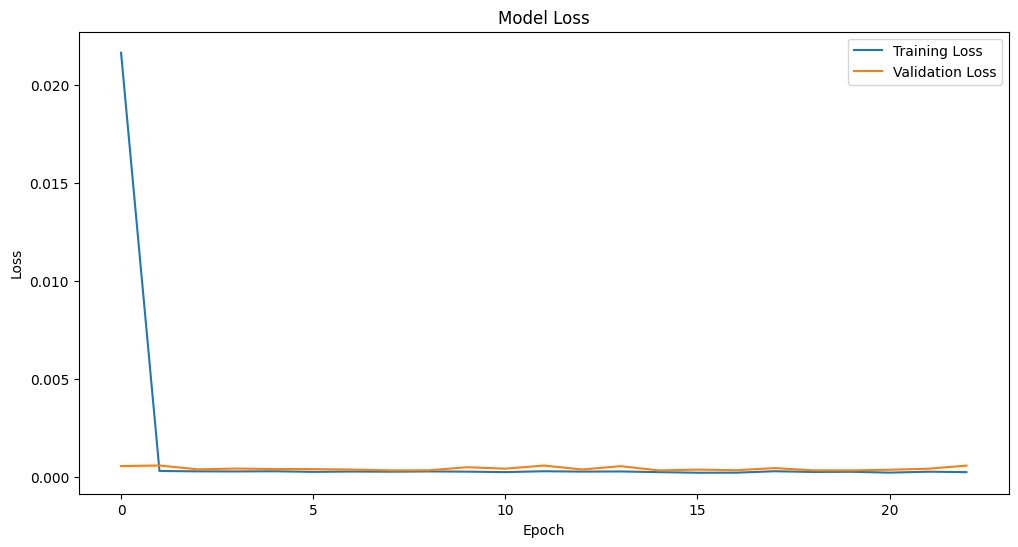

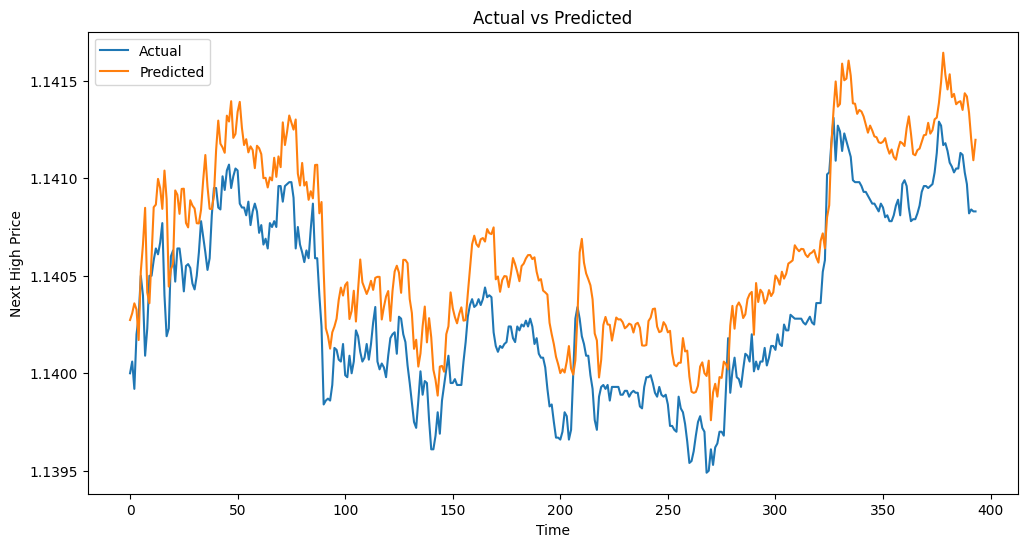

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import ffn
import os
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics import PrequentialError


# 1. Data Preparation

# Load data
ticker = 'AAPL'
data = pd.read_csv('../../datasets/FIXED_EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv').head(4000)

# Prepare features and target
data['Next_High'] = data['high'].shift(-1)  # Target variable: next period's high
data['Return'] = data['close'].pct_change()  # Price returns
data['Volatility'] = data['Return'].rolling(window=5).std()  # 5-period rolling volatility
data['High_Low_Range'] = (data['high'] - data['low']) / data['low']  # Intraday high-low range
data['Prev_Close_Rel_High'] = (data['close'].shift(1) - data['high']) / data['high']  # Previous close relative to high
data.dropna(inplace=True)

# Normalize the features
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = feature_scaler.fit_transform(data[['open', 'high', 'low', 'close', 'volume', 'Return', 'Volatility', 'High_Low_Range', 'Prev_Close_Rel_High']])

# Normalize the target
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(data[['Next_High']])

# Create dataset function for LSTM
def create_dataset(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step - 1):
        X.append(features[i:(i + time_step), :])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)

# Define time step for LSTM model
time_step = 60
X, y = create_dataset(scaled_features, scaled_target, time_step)

# Reshape data to fit PyTorch LSTM input: (samples, time_step, features)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split data into training, validation, and testing sets
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)  # 10% for validation
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Move tensors to the GPU if available
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# 2. Build and Train the LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))  # LSTM output
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 100
output_size = 1
num_layers = 2
num_epochs = 100
batch_size = 16
learning_rate = 0.01
patience = 8  # Early stopping patience

# Create LSTM model
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# DataLoader for batching
train_loader = torch.utils.data.DataLoader(dataset=list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)

# Lists to store the loss values for plotting
train_losses = []
val_losses = []

# Early stopping variables
best_val_loss = float('inf')
epochs_without_improvement = 0

# Train the model
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate the loss for each batch
        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()
        val_losses.append(val_loss)

    # Print the progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.6f}, Val Loss: {val_loss:.6f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        
        # Save the model
        torch.save(model.state_dict(), 'lstm_model.pth')
        print("Model saved.")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
            break


# 3. Model Evaluation
model.eval()  # Set model to evaluation mode

# Make predictions
with torch.no_grad():
    predictions = model(X_test)
    predictions = predictions.cpu().numpy()
    y_test = y_test.cpu().numpy()

# Inverse transform predictions and actual values to original scale
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# 4. Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Next High Price')
plt.legend()
plt.show()





In [2]:
# 3. DDM Drift Detection and Stream Test
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=25  # Minimum number of instances before checking for concept drift
)
detector = DDM(config=config)
metric = PrequentialError(alpha=1.0)

def stream_test(X_test, y_test, metric, detector):
    """Simulate data stream over X_test and y_test and detect concept drift."""
    drift_flag = False
    cumulative_error = 0

    for i, (X, y) in enumerate(zip(X_test, y_test)):
        # Predict and compute error
        y_pred = model(X.unsqueeze(0).to(device)).cpu().detach().numpy()
        error = float(abs(y_pred.item() - y.item()))

        # Update the detector with the error
        detector.update(error)
        cumulative_error += error

        # Check for drift
        status = detector.status
        if status["drift"] and not drift_flag:
            drift_flag = True
            accuracy = 1 - (cumulative_error / (i + 1))
            print(f"Concept drift detected at step {i}. Accuracy: {accuracy:.4f}")
            
    # Final accuracy
    accuracy = 1 - (cumulative_error / len(X_test))
    if not drift_flag:
        print("No concept drift detected")
    print(f"Final accuracy: {accuracy:.4f}\n")




# Run stream test
stream_test(X_test, y_test, metric, detector)

No concept drift detected
Final accuracy: 0.3626



# plotting

No concept drift detected
Final accuracy: 0.3626



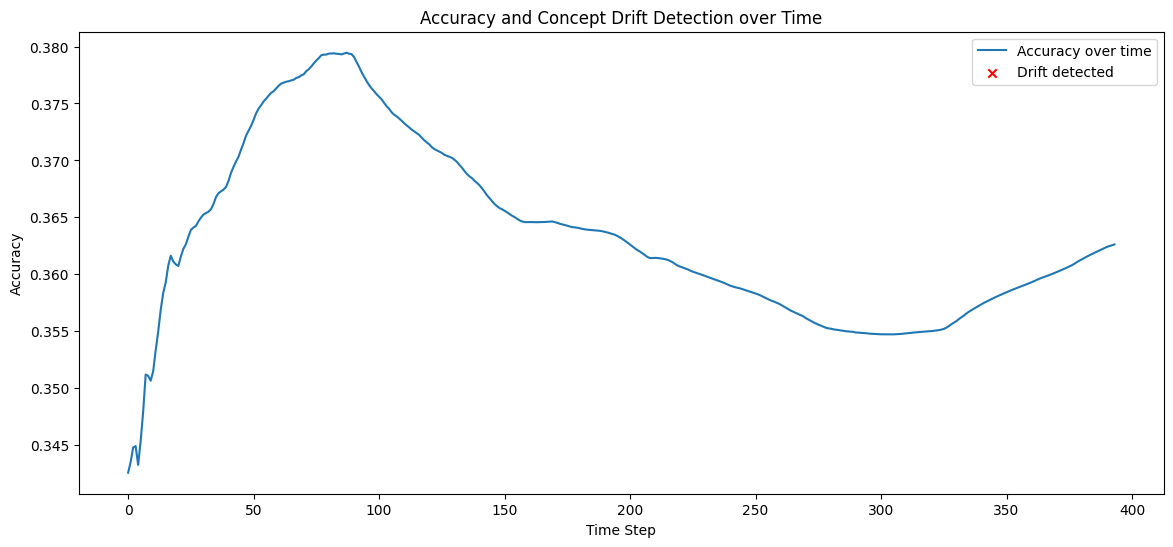

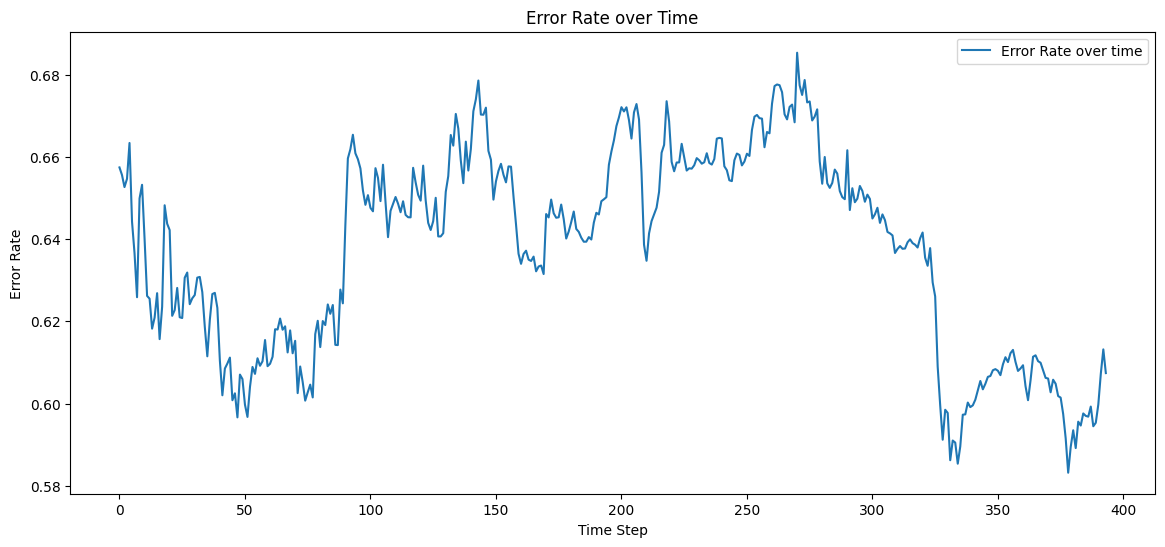

In [3]:
import matplotlib.pyplot as plt

# Updated stream_test function with tracking for plotting
def stream_test(X_test, y_test, detector):
    """Simulate data stream over X_test and y_test, detecting and plotting concept drift."""
    drift_flag = False
    cumulative_error = 0
    accuracies = []
    drift_points = []
    error_rates = []

    for i, (X, y) in enumerate(zip(X_test, y_test)):
        # Predict and compute error
        y_pred = model(X.unsqueeze(0).to(device)).cpu().detach().numpy()
        error = float(abs(y_pred.item() - y.item()))

        # Update the detector with the error
        detector.update(error)
        cumulative_error += error

        # Track accuracy and error rate
        accuracy = 1 - (cumulative_error / (i + 1))
        accuracies.append(accuracy)
        error_rates.append(error)

        # Check for drift
        status = detector.status
        if status["drift"] and not drift_flag:
            drift_flag = True
            drift_points.append(i)  # Record drift point
            print(f"Concept drift detected at step {i}. Accuracy: {accuracy:.4f}")

    # Final accuracy
    accuracy = 1 - (cumulative_error / len(X_test))
    if not drift_flag:
        print("No concept drift detected")
    print(f"Final accuracy: {accuracy:.4f}\n")

    return accuracies, drift_points, error_rates

# Run the stream test and get the data for plotting
accuracies, drift_points, error_rates = stream_test(X_test, y_test, detector)

# Plot the accuracy over time with drift points marked
plt.figure(figsize=(14, 6))

# Accuracy over time
plt.plot(accuracies, label='Accuracy over time')
plt.scatter(drift_points, [accuracies[i] for i in drift_points], color='red', marker='x', label='Drift detected')

# Formatting the plot
plt.title('Accuracy and Concept Drift Detection over Time')
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot error rate over time
plt.figure(figsize=(14, 6))
plt.plot(error_rates, label='Error Rate over time')
plt.title('Error Rate over Time')
plt.xlabel('Time Step')
plt.ylabel('Error Rate')
plt.legend()
plt.show()


## plotting diffrently 

Final accuracy: 0.3626

Concept drift detected at step 274. Accuracy: 0.3557
Concept drift detected at step 275. Accuracy: 0.3556
Concept drift detected at step 276. Accuracy: 0.3555
Concept drift detected at step 277. Accuracy: 0.3554
Concept drift detected at step 278. Accuracy: 0.3553
Concept drift detected at step 279. Accuracy: 0.3553
Concept drift detected at step 280. Accuracy: 0.3552
Concept drift detected at step 281. Accuracy: 0.3552
Concept drift detected at step 282. Accuracy: 0.3551
Concept drift detected at step 283. Accuracy: 0.3551
Concept drift detected at step 284. Accuracy: 0.3551
Concept drift detected at step 285. Accuracy: 0.3550
Concept drift detected at step 286. Accuracy: 0.3550
Concept drift detected at step 287. Accuracy: 0.3550
Concept drift detected at step 288. Accuracy: 0.3550
Concept drift detected at step 289. Accuracy: 0.3549
Concept drift detected at step 290. Accuracy: 0.3549
Concept drift detected at step 291. Accuracy: 0.3549
Concept drift detected

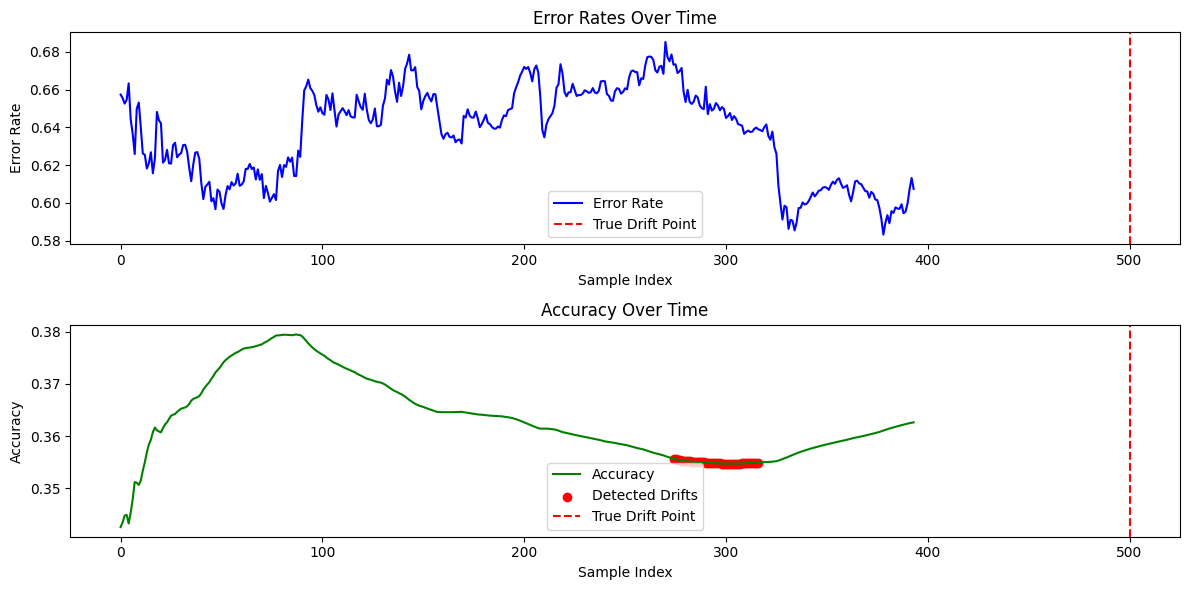

In [4]:

config = DDMConfig(
    warning_level=0.09,
    drift_level=1.12,
    min_num_instances=2  # Minimum number of instances before checking for concept drift
)
detector = DDM(config=config)
metric = PrequentialError(alpha=1.0)

def stream_test(X_test, y_test, metric, detector):
    """Simulate data stream over X_test and y_test and detect concept drift."""
    drift_points = []
    cumulative_error = 0
    errors = []

    for i, (X, y) in enumerate(zip(X_test, y_test)):

        y_pred = model(X.unsqueeze(0).to(device)).cpu().detach().numpy()
        # Calculate error
        error = float(abs(y_pred.item() - y.item()))
        errors.append(error)

        # Update the detector with the error
        detector.update(error)
        cumulative_error += error

        # Check for drift
        status = detector.status
        if status["drift"]:
            drift_points.append(i)
            accuracy = 1 - (cumulative_error / (i + 1))
            print(f"Concept drift detected at step {i}. Accuracy: {accuracy:.4f}")

    # Final accuracy
    final_accuracy = 1 - (cumulative_error / len(X_test))
    print(f"Final accuracy: {final_accuracy:.4f}\n")
    
    return drift_points, errors

# 5. Run stream test
drift_points, errors = stream_test(X_test, y_test, metric, detector)

# 5. Run stream test
drift_points, errors = stream_test(X_test, y_test, metric, detector)

# 6. Visualize results
plt.figure(figsize=(12, 6))

# Plot error rates
plt.subplot(2, 1, 1)
plt.plot(errors, label='Error Rate', color='blue')
plt.axvline(x=500, color='red', linestyle='--', label='True Drift Point')
plt.title('Error Rates Over Time')
plt.xlabel('Sample Index')
plt.ylabel('Error Rate')
plt.legend()

# Plot detected drifts
plt.subplot(2, 1, 2)
plt.plot(range(len(errors)), [1 - (sum(errors[:i + 1]) / (i + 1)) for i in range(len(errors))], label='Accuracy', color='green')
plt.scatter(drift_points, [1 - (sum(errors[:i + 1]) / (i + 1)) for i in drift_points], color='red', label='Detected Drifts')
plt.axvline(x=500, color='red', linestyle='--', label='True Drift Point')
plt.title('Accuracy Over Time')
plt.xlabel('Sample Index')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Detector efficeny measurement

Final accuracy: 0.5668



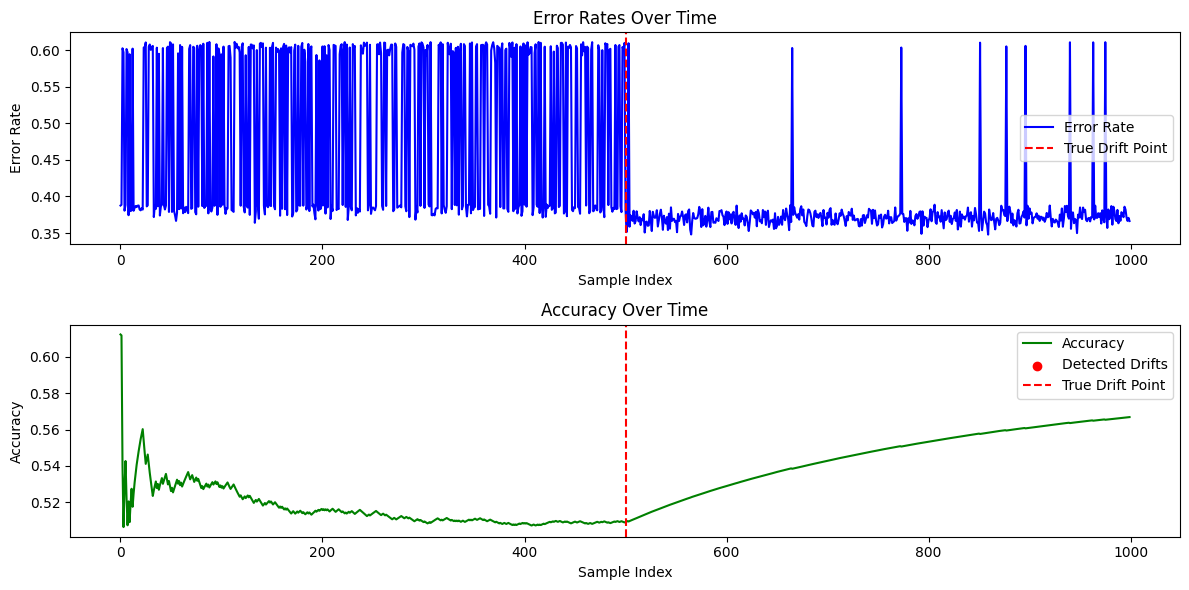

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics import PrequentialError


# 1. Create synthetic data with an abrupt drift
def create_synthetic_data(num_samples=1000):
    """Create synthetic data with an abrupt drift."""
    X = np.random.randn(num_samples, 1)  # Initial distribution
    y = (X > 0).astype(np.float32)  # Binary classification based on X
    
    # Introduce a drift at sample 500
    X[500:] += 2  # Shift the distribution
    y[500:] = (X[500:] > 0).astype(np.float32)  # Update labels based on the new distribution
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X_synthetic, y_synthetic = create_synthetic_data()

# 2. Create a simple model (adjust as needed for your task)
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

model = SimpleModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

# 3. Initialize the DDM detector and metric
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=25  # Minimum number of instances before checking for concept drift
)
detector = DDM(config=config)
metric = PrequentialError(alpha=1.0)

# 4. Stream test function
def stream_test(X_test, y_test, metric, detector):
    """Simulate data stream over X_test and y_test and detect concept drift."""
    drift_points = []
    cumulative_error = 0
    errors = []

    for i, (X, y) in enumerate(zip(X_test, y_test)):
        # Predict and compute error
        y_pred = model(X.unsqueeze(0)).cpu().detach().numpy()
        error = float(abs(y_pred.item() - y.item()))
        errors.append(error)

        # Update the detector with the error
        detector.update(error)
        cumulative_error += error

        # Check for drift
        status = detector.status
        if status["drift"]:
            drift_points.append(i)
            accuracy = 1 - (cumulative_error / (i + 1))
            print(f"Concept drift detected at step {i}. Accuracy: {accuracy:.4f}")

    # Final accuracy
    final_accuracy = 1 - (cumulative_error / len(X_test))
    print(f"Final accuracy: {final_accuracy:.4f}\n")
    
    return drift_points, errors

# 5. Run stream test
drift_points, errors = stream_test(X_synthetic, y_synthetic, metric, detector)

# 6. Visualize results
plt.figure(figsize=(12, 6))

# Plot error rates
plt.subplot(2, 1, 1)
plt.plot(errors, label='Error Rate', color='blue')
plt.axvline(x=500, color='red', linestyle='--', label='True Drift Point')
plt.title('Error Rates Over Time')
plt.xlabel('Sample Index')
plt.ylabel('Error Rate')
plt.legend()

# Plot detected drifts
plt.subplot(2, 1, 2)
plt.plot(range(len(errors)), [1 - (sum(errors[:i + 1]) / (i + 1)) for i in range(len(errors))], label='Accuracy', color='green')
plt.scatter(drift_points, [1 - (sum(errors[:i + 1]) / (i + 1)) for i in drift_points], color='red', label='Detected Drifts')
plt.axvline(x=500, color='red', linestyle='--', label='True Drift Point')
plt.title('Accuracy Over Time')
plt.xlabel('Sample Index')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
